In [1]:
## Breast Cancer Classification Transfer Learning VGG16
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import tensorflow as tf

from sklearn.utils import class_weight  # Import class_weight
from sklearn.metrics import confusion_matrix, classification_report

2025-05-10 12:56:38.107896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-10 12:56:38.181491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 12:56:38.202103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 12:56:38.315056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 12:56:40.188178: W tensorflow/compiler/tf2

In [2]:
### Creating Dataset
print(os.listdir('../breast_full_dataset'))

### Train Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.vgg19 import preprocess_input as base_preprocess
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as base_preprocess

['Benign', 'Malignant']


In [5]:
# Here, we add random rotation, zoom, brightness, vertical flip, etc.
image_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,
    validation_split=0.15,
    rotation_range=20,        # Random rotation in degrees
    zoom_range=0.1,           # Random zoom
    brightness_range=[1.0, 1.5],  # Brightness adjustment
    vertical_flip=True,       # Flip vertically
)

data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224, 224)

train_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset="training"
)

test_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset="validation"
)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


In [4]:
image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               validation_split=0.15)
data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224,224)

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].


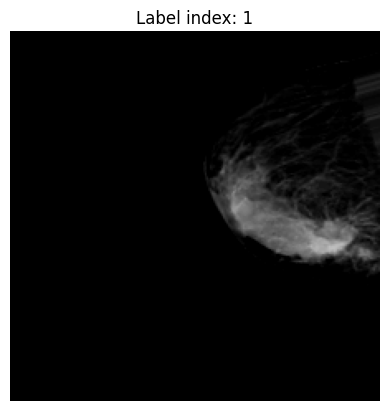

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5137255].


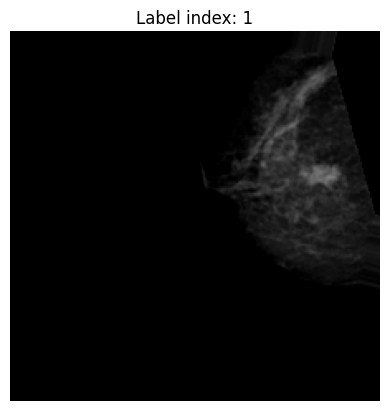

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


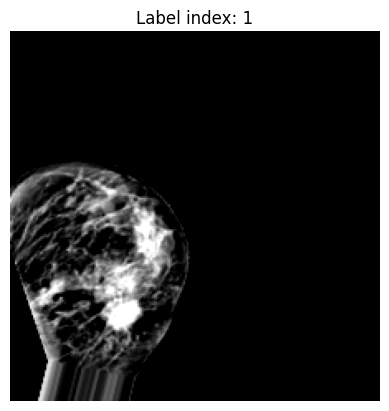

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..1.0].


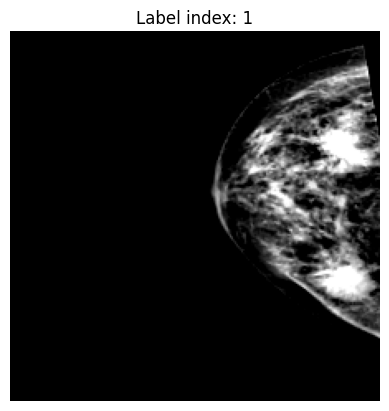

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


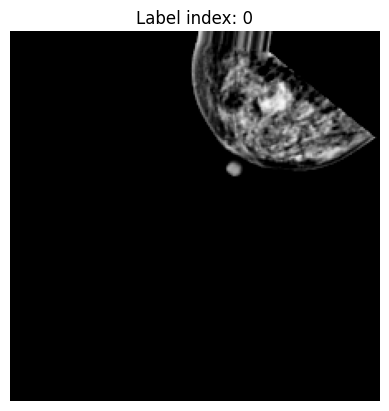

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.45882356].


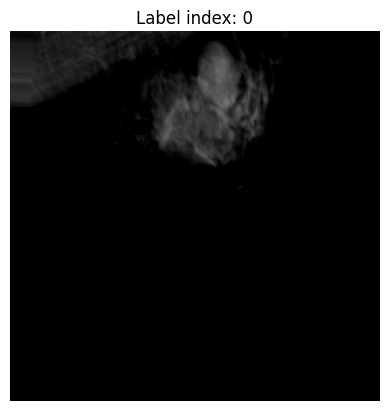

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].


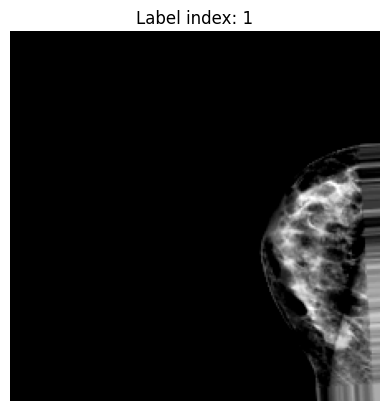

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].


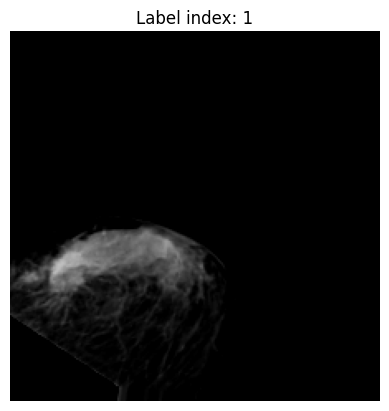

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images (and their labels) from the training generator
images, labels = next(train_image_gen)  # images.shape == (batch_size, height, width, channels)

# Display the first 5 images (or as many as you like)
num_to_show = len(images)
for i in range(num_to_show):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i])  # Convert floats to uint8 for display (if needed)
    plt.title(f"Label index: {np.argmax(labels[i])}")  # Convert one-hot to class index (if categorical)
    plt.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.22352946].


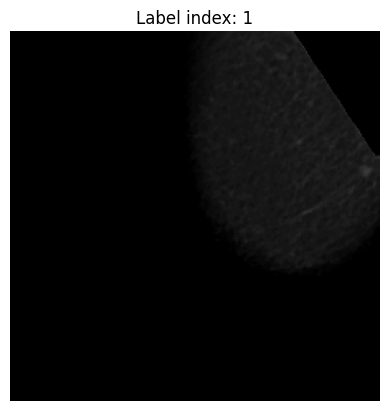

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.7647059].


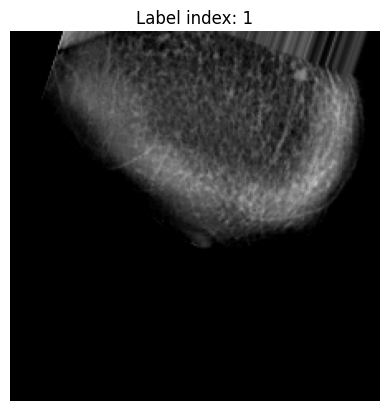

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].


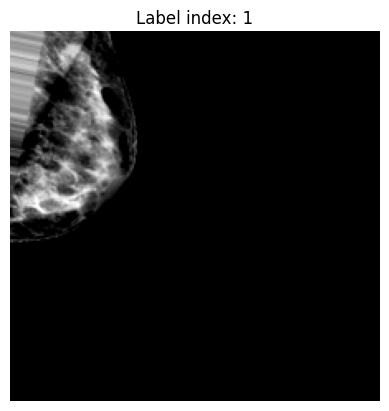

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5294118].


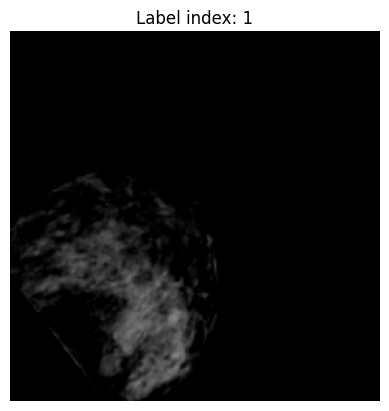

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


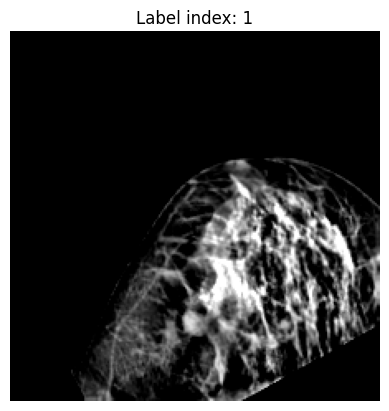

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


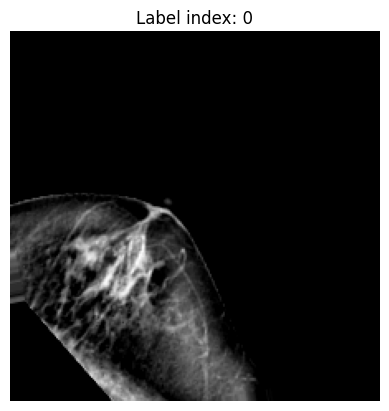

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


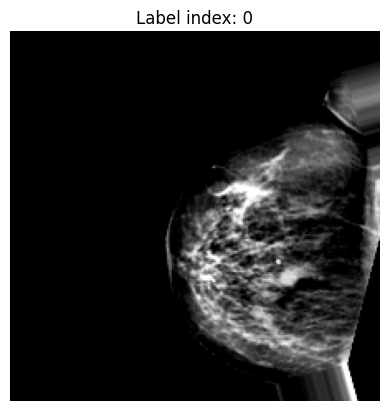

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


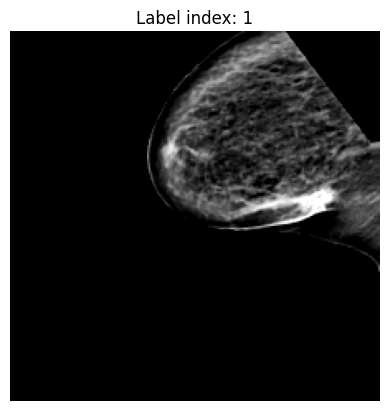

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images (and their labels) from the training generator
images, labels = next(train_image_gen)  # images.shape == (batch_size, height, width, channels)

# Display the first 5 images (or as many as you like)
num_to_show = len(images)
for i in range(num_to_show):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i])  # Convert floats to uint8 for display (if needed)
    plt.title(f"Label index: {np.argmax(labels[i])}")  # Convert one-hot to class index (if categorical)
    plt.axis('off')
    plt.show()


In [5]:
print(test_image_gen.class_indices)
train_labels = train_image_gen.classes  # Extracts the classes (integer encoded labels)

{'Benign': 0, 'Malignant': 1}


In [6]:
# Get the unique class names and their corresponding indices
class_names = list(train_image_gen.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['Benign', 'Malignant']


In [7]:
# Compute class weights based on the labels
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

# Create a dictionary mapping class indices to weights
class_wt_dict = dict(enumerate(class_weights))

# Output the computed class weights
print(f"Class weights: {class_wt_dict}")

Class weights: {0: np.float64(1.5144724556489262), 1: np.float64(0.7464335020708698)}


In [8]:
## Transfer Learning using VGG16 Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

x = vgg16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
tl_model = Model(inputs=vgg16_model.input, outputs=x)

optimizer = "Adam"
tl_model.summary()
tl_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

I0000 00:00:1739688663.162803    8429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 27,563,330 (105.15 MB)

 Trainable params: 12,847,618 (49.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Clear the session
tf.keras.backend.clear_session()

# Reset the tracked memory stats
tf.config.experimental.reset_memory_stats('GPU:0')

In [11]:
## Model Training
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

filename = "models/t2_breast_VGGAdam_IRN_PreProcess-epoch{epoch:02d}.keras"
dirname = "logs_test2/breast_VGGAdam_IRNPreProcessing"


lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint(filepath= filename, save_best_only=True, monitor='val_accuracy',verbose=1)
tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

#callback_list = [model_chkpt, lr_reduce, early_stop, tensorboard]
callback_list = [model_chkpt, lr_reduce, tensorboard]
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1739688725.343055    8606 service.cc:148] XLA service 0x7b0fe0002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739688725.343087    8606 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-02-16 12:22:05.413119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739688725.755899    8606 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-16 12:22:06.194864: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

  3/811 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.4514 - loss: 1.2735  

I0000 00:00:1739688730.473448    8606 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6169 - loss: 0.7661
Epoch 1: val_accuracy improved from -inf to 0.67308, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch01.keras


2025-02-16 12:23:24.182510: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3082813440 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.6170 - loss: 0.7660 - val_accuracy: 0.6731 - val_loss: 0.6711 - learning_rate: 0.0010
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7945 - loss: 0.4482
Epoch 2: val_accuracy improved from 0.67308 to 0.72465, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch02.keras


2025-02-16 12:25:13.970854: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3082813440 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 110s 136ms/step - accuracy: 0.7945 - loss: 0.4482 - val_accuracy: 0.7247 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8301 - loss: 0.3813
Epoch 3: val_accuracy did not improve from 0.72465


2025-02-16 12:27:29.546737: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3082813440 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 136s 167ms/step - accuracy: 0.8301 - loss: 0.3813 - val_accuracy: 0.7063 - val_loss: 0.7026 - learning_rate: 0.0010
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8572 - loss: 0.3277
Epoch 4: val_accuracy improved from 0.72465 to 0.73252, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch04.keras


2025-02-16 12:29:55.084237: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3082813440 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 146s 180ms/step - accuracy: 0.8571 - loss: 0.3277 - val_accuracy: 0.7325 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8745 - loss: 0.2917
Epoch 5: val_accuracy improved from 0.73252 to 0.74476, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch05.keras


2025-02-16 12:32:25.115669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3082813440 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 150s 185ms/step - accuracy: 0.8745 - loss: 0.2916 - val_accuracy: 0.7448 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8713 - loss: 0.2950
Epoch 6: val_accuracy did not improve from 0.74476
811/811 ━━━━━━━━━━━━━━━━━━━━ 164s 202ms/step - accuracy: 0.8713 - loss: 0.2950 - val_accuracy: 0.7220 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9035 - loss: 0.2515
Epoch 7: val_accuracy improved from 0.74476 to 0.74650, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch07.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 163s 202ms/step - accuracy: 0.9035 - loss: 0.2515 - val_accuracy: 0.7465 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8989 - loss: 0.2411
Epoch 8: val_accuracy improved from 0.74650 to 0.75787, saving model to models/t2_breast_VGGAdam_IRN_PreProcess-epoch08.kera

143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6651 - loss: 1.0461
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


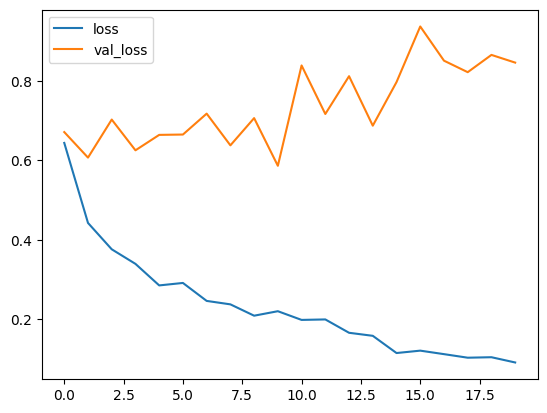

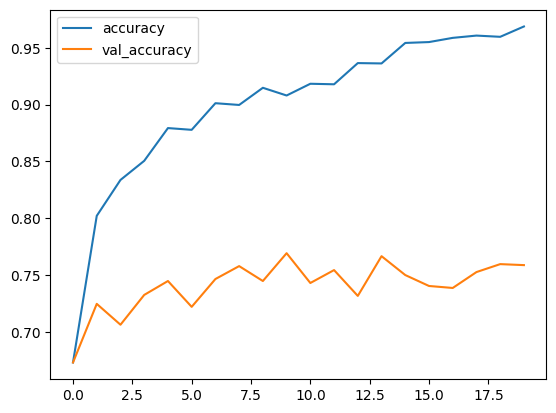

In [12]:
### Model Evaluation
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()
metrics[["accuracy","val_accuracy"]].plot()
tl_model.evaluate(test_image_gen)
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

In [13]:
test_labels = test_image_gen.classes
from tensorflow.keras.models import load_model

final_model = load_model("./models/t2_breast_VGGAdam_IRN_PreProcess-epoch10.keras")
predictions = final_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes

143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


Normalized confusion matrix
[[0.61904762 0.38095238]
 [0.15665796 0.84334204]]
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       378
           1       0.82      0.84      0.83       766

    accuracy                           0.77      1144
   macro avg       0.74      0.73      0.73      1144
weighted avg       0.77      0.77      0.77      1144



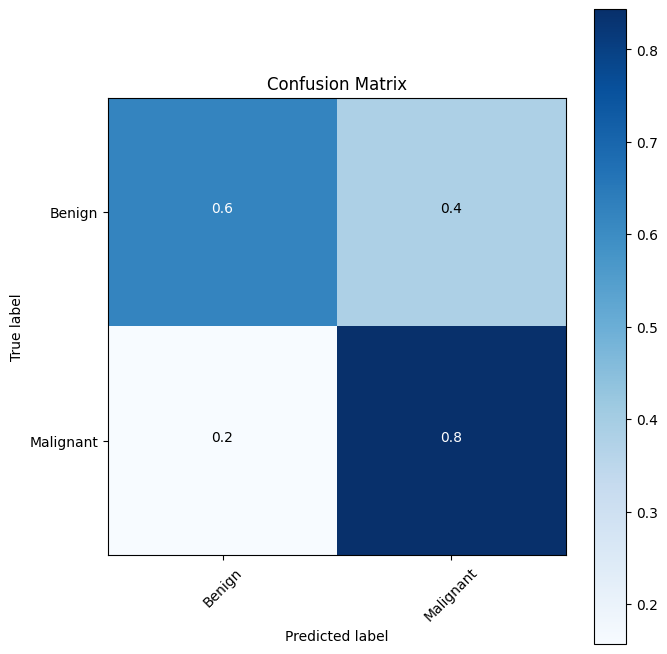

In [14]:
cm = confusion_matrix(test_labels, predictions)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)
print(classification_report(test_image_gen.classes, predictions, zero_division=0))


In [14]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       378
           1       0.87      0.76      0.81       766

    accuracy                           0.76      1144
   macro avg       0.74      0.76      0.75      1144
weighted avg       0.78      0.76      0.77      1144



In [ ]:
precision    recall  f1-score   support

           0       0.65      0.72      0.68       378
           1       0.85      0.81      0.83       766

    accuracy                           0.78      1144
   macro avg       0.75      0.76      0.75      1144
weighted avg       0.78      0.78      0.78      1144